In [1]:
from fastai import *
from fastbook import *

/Users/tobiasbudig/opt/anaconda3/lib/python3.8/site-packages/fastbook/__init__.py:22: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
!ls

chest_xray_data           export.pkl                x-ray-deep-learning.ipynb


In [3]:
Path.BASE_PATH = Path('./chest_xray_data/')
path = Path.BASE_PATH
Path.BASE_PATH.ls()


(#3) [Path('.DS_Store'),Path('pneumonia'),Path('normal')]

In [4]:
fns = get_image_files(path)
fns

(#5856) [Path('pneumonia/person63_bacteria_306.jpeg'),Path('pneumonia/person1438_bacteria_3721.jpeg'),Path('pneumonia/person755_bacteria_2659.jpeg'),Path('pneumonia/person478_virus_975.jpeg'),Path('pneumonia/person661_bacteria_2553.jpeg'),Path('pneumonia/person276_bacteria_1296.jpeg'),Path('pneumonia/person1214_bacteria_3166.jpeg'),Path('pneumonia/person1353_virus_2333.jpeg'),Path('pneumonia/person26_bacteria_122.jpeg'),Path('pneumonia/person124_virus_238.jpeg')...]

In [ ]:
verify_images(fns)

In [5]:
xrays = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)



In [6]:
dls = xrays.dataloaders(path)
dls.bs

64

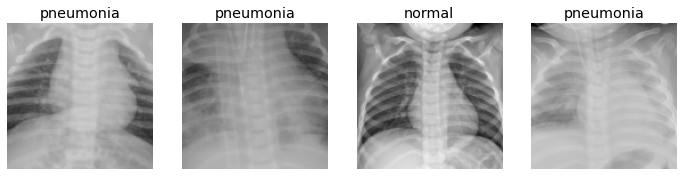

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(3, nrows=1)

In [ ]:
learn.export()

In [8]:
learn_inf = load_learner("./export.pkl")

In [9]:
from ipywidgets import VBox
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description="Classify")

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    
    #get predictions
    pred, pred_idx, probs = learn_inf.predict(img)

    
    lbl_pred.value = f"Predictions: {pred}; Probability: {probs[pred_idx]:.04f}"
    lbl_pred
    
btn_run.on_click(on_click_classify)
VBox([widgets.Label("Select Image"), btn_upload, btn_run, out_pl, lbl_pred])

## CAM

In [24]:
img_test = PILImage.create("./chest_xray_data/pneumonia/person1353_virus_2333.jpeg")
x, = first(dls.test_dl([img_test]))
x

TensorImage([[[[0.5020, 0.5020, 0.4980,  ..., 0.3647, 0.3765, 0.3804],
          [0.5255, 0.5412, 0.5333,  ..., 0.3882, 0.3961, 0.4000],
          [0.5686, 0.5725, 0.5686,  ..., 0.4039, 0.4157, 0.4157],
          ...,
          [0.8078, 0.8275, 0.8431,  ..., 0.6863, 0.6471, 0.6627],
          [0.8235, 0.8314, 0.8431,  ..., 0.6627, 0.6157, 0.6157],
          [0.7647, 0.8118, 0.8118,  ..., 0.6471, 0.6157, 0.5961]],

         [[0.5020, 0.5020, 0.4980,  ..., 0.3647, 0.3765, 0.3804],
          [0.5255, 0.5412, 0.5333,  ..., 0.3882, 0.3961, 0.4000],
          [0.5686, 0.5725, 0.5686,  ..., 0.4039, 0.4157, 0.4157],
          ...,
          [0.8078, 0.8275, 0.8431,  ..., 0.6863, 0.6471, 0.6627],
          [0.8235, 0.8314, 0.8431,  ..., 0.6627, 0.6157, 0.6157],
          [0.7647, 0.8118, 0.8118,  ..., 0.6471, 0.6157, 0.5961]],

         [[0.5020, 0.5020, 0.4980,  ..., 0.3647, 0.3765, 0.3804],
          [0.5255, 0.5412, 0.5333,  ..., 0.3882, 0.3961, 0.4000],
          [0.5686, 0.5725, 0.5686,  .

In [25]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [26]:
hook_output = Hook()
hook = learn_inf.model[0].register_forward_hook(hook_output.hook_func)

In [27]:
with torch.no_grad(): output = learn_inf.model.eval()(x)

In [28]:
act = hook_output.stored[0]
F.softmax(output, dim=-1)

tensor([[0.0181, 0.9819]])

In [29]:
dls.vocab

(#2) ['normal','pneumonia']

In [30]:
x.shape

torch.Size([1, 3, 128, 128])

In [31]:
cam_map = torch.einsum("ck,kij->cij", learn_inf.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 4, 4])

In [32]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
x_dec

TensorImage([[[128, 128, 127,  ...,  93,  96,  97],
         [134, 138, 136,  ...,  99, 101, 102],
         [145, 146, 145,  ..., 103, 106, 106],
         ...,
         [206, 211, 215,  ..., 175, 165, 169],
         [210, 212, 215,  ..., 169, 157, 157],
         [195, 207, 207,  ..., 165, 157, 152]],

        [[128, 128, 127,  ...,  93,  96,  97],
         [134, 138, 136,  ...,  99, 101, 102],
         [145, 146, 145,  ..., 103, 106, 106],
         ...,
         [206, 211, 215,  ..., 175, 165, 169],
         [210, 212, 215,  ..., 169, 157, 157],
         [195, 207, 207,  ..., 165, 157, 152]],

        [[128, 128, 127,  ...,  93,  96,  97],
         [134, 138, 136,  ...,  99, 101, 102],
         [145, 146, 145,  ..., 103, 106, 106],
         ...,
         [206, 211, 215,  ..., 175, 165, 169],
         [210, 212, 215,  ..., 169, 157, 157],
         [195, 207, 207,  ..., 165, 157, 152]]])

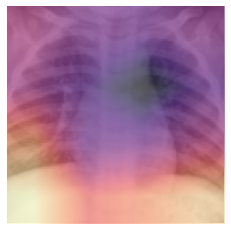

In [33]:
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0, 128, 128,0), interpolation="bilinear", cmap="magma")